In [174]:
import sys

import darkdetect
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot as plt

from examples.gen_unit_square import gen_unit_square
from fem.matrix.load_vector import load_node
from fem.matrix.stiffness_matrix import stiffness_node
from fem.mesh.mesh_2d import make_mesh
from fem.plot.plot_mesh import plot_mesh
from fem.plot.plot_pot import plot_pot

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
## matplotlib settings
if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True
})

## Setup problem
### 1) Mesh generation

In [176]:
sys.argv.append('-nopopup')
gen_unit_square()
msh = make_mesh()

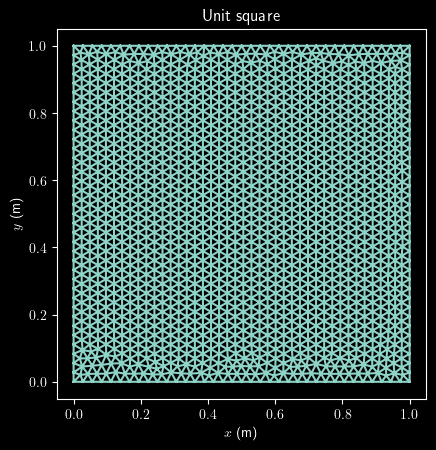

In [177]:
plot_mesh(msh, title='Unit square')

### 2) Right hand side

In [178]:
def u_ana(p: np.ndarray) -> np.ndarray | float:
    return np.sin(np.pi*p[0])*np.sin(np.pi*p[1])

def f(p: np.ndarray):
    return 2*np.pi**2*u_ana(p)

b = load_node(msh, f, 3)

### 3) Matrix assembly

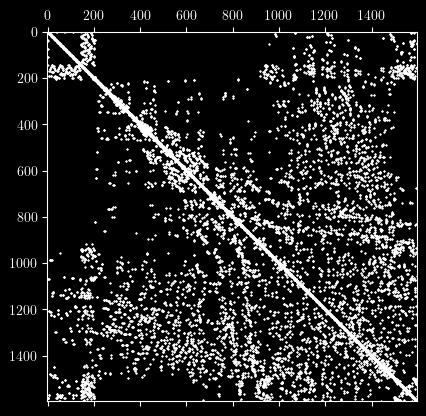

In [179]:
K = stiffness_node(msh)
plt.figure()
plt.spy(K, markersize=.5)

## Boundary conditions

### 1) BC function $g$

In [180]:
idx_bc = msh.nodes_bnd
idx_dof = np.setdiff1d(np.arange(msh.N), idx_bc)

# TODO: Make a function g and call load_node
u_bc = 0 * np.ones((idx_bc.size,))

### 2) Inflate system

In [181]:
K = K.tocsr()
b = b[idx_dof] - K[idx_dof,:][:,idx_bc] @ u_bc
K = K[idx_dof,:][:,idx_dof]

## Solution
### 1) Solve system

In [182]:
u_h = np.empty((msh.N,))
u_h[idx_bc] = u_bc
u_h[idx_dof], info = sp.linalg.gmres(K, b)
print(f"gmres terminated with exit code {info}")

gmres terminated with exit code 0


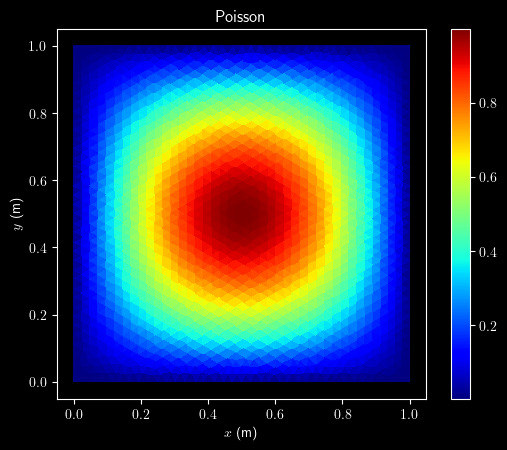

In [183]:
plot_pot(msh, u_h, title=r'Poisson', cmap='jet')

### 2) Calculate L2 error

In [184]:
u = u_ana(msh.nodes.T)
err = np.linalg.norm(u_h - u) / np.linalg.norm(u)
print(f"Relative L2 error between numerical and analytical solution = {100*err:.4f}%")

Relative L2 error between numerical and analytical solution = 0.0050%
